# PAX8 and epithelials - Seurat analysis

Please, save the anndata object as follows

```
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is not log
```


In [1]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(SoupX)

luz_colors = c('#c466b0', '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')

colors = c(luz_colors, 
           brewer.pal(n=12, name = 'Paired'), 
           brewer.pal(n=8, name = 'Set2'),
          brewer.pal(n=8, name = 'Set3'),
          brewer.pal(n=8, name = 'Accent'),
          brewer.pal(n=8, name = 'Pastel1'))


downsample_data = function(anndataO, var = 'annotated_clusters', N=200){
    samples = list()
    for (cl in unique(anndataO@meta.data[,var]) ){
        cells = colnames(anndataO)[ anndataO@meta.data[,var] == cl ]
        samples[[cl]] = cells
        if( length(cells) > N )
            samples[[cl]] = sample(cells, size = N, replace = F)
    }
    anndataOF = subset(anndataO, cells = unlist(samples))
    
    gene_counts = tabulate(anndataOF@assays$RNA@counts@i + 1)
    anndataOF = subset(anndataOF, features = names(gene_counts)[ gene_counts > 3 ] )
    
    return(anndataOF)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: splines

Loading required package: foreach

Loaded gam 1.20


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /home/jovyan/my-conda-envs/R_Seurat3/lib/libblas.so.3.8.0
LAPACK: /home/jovyan/my-conda-envs/R_Seurat3/lib/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SoupX_1.5.0        cowplot_1.1.1      pheatmap_1.0.12    ggplot2_3.3.3     
 [5] harmony_1.0        Rcpp_1.0.6         gam_1.20           foreach_1.5.1     
 [9] destiny_3.4.0      RColorBrewer_1.1-2 dplyr_1.0.5        Seurat_3.

In [3]:
markers = list( 'somatic progenitor' = c('WT1', 'NR5A1'),
                'supporting lineage' = c('WNT6', 'WIPF3', 'GATA4'),
                'coelomic epi' = c('LRRN4', 'UPK3B', 'KLK11'),
                sLGR5 = c('LGR5', 'TSPAN8', 'CXCR4'),
                sPAX8 = c('PAX8', 'PLAU', 'CXCL12', 'CXCL14', 'SLIT1', 'SLIT2'),
                OSE= c('LHX9', 'LHX2', 'CALB2'),
                'pre-granulosa' = c( "KITLG", 'CSRNP1', 'CYP26B1', 'RSPO1', 'WNT4', 'FOXL2',  'OSR1', 'IRX3', 'CYP19A1',  'NOTCH3',  'HEYL', 'PROK1', 'RDH10', 'BMP2'),
                'WNT/beta-catenin' = c('AXIN2', 'WISP2', 'WIF1'),
                Sertoli = c('SOX9',  'AMH', 'INHBB', 'CITED1', 'CLDN11', 'WFDC2', 'CTNNA2'),
                'Fetal Leydig' = c('FDX1', 'INSL3',  'PTCH1',  'PTCH2', 'CYP17A1'),
                mesenchymal = c('DCN', 'PDGFRA', 'COL1A1'),
                cycling = c('CDK1', 'MKI67'),
                quiescent = c('CDKN1B'),
                male = c('SRY', 'RPS4Y1','DDX3Y')       
)
unlist(markers)[ which(duplicated(unlist(markers))) ]

named character(0)

# Process with Seurat from raw

In [4]:
# Load and pre-process wth standard workflow
anndata <- ReadH5AD(file = '/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.h5ad')
allgenes = rownames(anndata)
anndata

Warning message:
“Functionality for reading and writing H5AD files is being moved to SeuratDisk
For more details, please see https://github.com/mojaveazure/seurat-disk
and https://mojaveazure.github.io/seurat-disk/index.html”
Pulling expression matrices and metadata

Data is unscaled

Creating assay object

Storing X as raw and raw as counts

No variable feature expression found in h5ad file

No dimensional reduction information found

Assembling Seurat object

No nearest-neighbor graph

No additional layers found



An object of class Seurat 
28230 features across 319081 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

In [5]:
# # Remove CCG
# ccgs = read.csv('figures_manual_annotation/cell_cycle_genes.csv', stringsAsFactors = F)$X0
# anndata = subset(anndata, features = setdiff(allgenes, ccgs) )

In [6]:
# Add metadata
meta = read.csv('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.csv', stringsAsFactors = F)
names(meta)[1] = 'index'
anndata@meta.data$is_doublet = meta$is_doublet[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$seurat_clusters_v0 = meta$seurat_clusters[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$clusters = meta$clusters_manual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$PCW = meta$PCW[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)
anndata@meta.data$sex = meta$sex[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$TP = meta$TP[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$process = meta$process[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$individual = meta$individual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$sample_source = meta$sample_source[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$scrublet_cluster_score = meta$scrublet_cluster_score[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)
table(anndata@meta.data$clusters)


               Coel Epi                Doublets             Endothelial 
                  12001                    5639                   10948 
             Epithelial               Erythroid              Germ cells 
                   9679                    7423                   11388 
                 Immune                   lowQC Mesenchymal_GATA2_NR2F1 
                   5157                   20815                   77319 
   Mesenchymal_LHX9_ARX             Metanephros                  Neural 
                  51992                    1503                    2530 
                     PV                 Sertoli       Supporting_female 
                   7440                   37796                   57451 

In [7]:
# subset datasets to contain clusters of interest and remove doublets
clusters_of_interest = c('Supporting_female', 'Coel Epi', 'Sertoli', 'Epithelial')
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, clusters %in% clusters_of_interest)))
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, is_doublet == 'False' )))
anndata
all(clusters_of_interest %in% anndata@meta.data$clusters)
table(anndata@meta.data$clusters)

An object of class Seurat 
28230 features across 113934 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

[1] TRUE


         Coel Epi        Epithelial           Sertoli Supporting_female 
            11578              9324             37554             55478 

In [8]:
anndata@meta.data$clusters_previous = 'new'

# Add metadata - supporting
meta_sup = read.csv('/nfs/team292/lg18/with_valentina/supporting_nocycling_annotation.csv', stringsAsFactors = F)

anndata@meta.data$clusters_previous[ rownames(anndata@meta.data) %in% meta_sup$X ] = 
meta_sup$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_sup$X], meta_sup$X) ]

# Add metadata - Epithelials
meta_sup = read.csv('/nfs/team292/lg18/with_valentina/epithelial_annotation.csv', stringsAsFactors = F)

anndata@meta.data$clusters_previous[ rownames(anndata@meta.data) %in% meta_sup$X ] = 
meta_sup$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_sup$X], meta_sup$X) ]


table(anndata@meta.data$clusters_previous)


            coelEpi         Epi_cycling           Epi_GATA3   Epi_MesoDuct_CUBN 
               4385                 816                 595                1501 
Epi_MesoDuct_TFAP2B        Epi_MullDuct          Epididymis    FetalLeydig-like 
                337                4644                 289                 460 
                new         ovarianSurf        preGC_I_OSR1            preGC_II 
              22519                5148               11714                6669 
   preGC_II_hypoxia           preGC_III     preGC_III_Notch             Sertoli 
               8180                7871                2409               19227 
        Sertoli_low       Sertoli_WFDC2              sKITLG               sLGR5 
               8763                1074                1245                2660 
             sPAX8b              sPAX8m 
               1783                1645 

In [13]:
# subset datasets to contain clusters of interest and remove doublets
# subset datasets to contain clusters of interest and remove doublets
clusters2keep = c(grep('Epi_', anndata@meta.data$clusters_previous, value = T),
                    grep('Epididymis', anndata@meta.data$clusters_previous, value = T),
                    grep('sPAX8', anndata@meta.data$clusters_previous, value = T))
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, clusters_previous %in% clusters2keep)))
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, is_doublet == 'False' )))
anndata
table(anndata@meta.data$clusters_previous)

An object of class Seurat 
28230 features across 10794 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)


          Epi_GATA3   Epi_MesoDuct_CUBN Epi_MesoDuct_TFAP2B        Epi_MullDuct 
                595                1501                 337                4644 
         Epididymis              sPAX8b              sPAX8m 
                289                1783                1645 

In [14]:
# anndata = downsample_data(anndata, 'clusters_previous', N = 1000)

In [15]:
# basic gene/cell filtering
message('Removing ', sum(anndata@meta.data$nCount_RNA < 500), ' cells with less than 500 nCount_RNA' )
anndata <- subset(anndata, cells = colnames(anndata)[ anndata@meta.data$nCount_RNA >= 500 ] )
                    
gene_counts = tabulate(anndata@assays$RNA@counts@i+1)
message('Removing ', sum(gene_counts <= 3), ' genes expressed in 3 or less cells' )
anndata <- subset(anndata, features = names(gene_counts)[ gene_counts > 3 ] )

Removing 0 cells with less than 500 nCount_RNA

Removing 6234 genes expressed in 3 or less cells



In [16]:
# basic preprocessing
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)
anndata <- FindVariableFeatures(anndata)
anndata <- ScaleData(anndata, features = rownames(anndata))
anndata

Centering and scaling data matrix



An object of class Seurat 
28230 features across 10794 samples within 1 assay 
Active assay: RNA (28230 features, 2000 variable features)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  G2E3, PSRC1, RANGAP1, GAS2L3, RAD51, CKAP5, AURKA, CENPA, CENPE, CTCF 
	   BUB1, UBR7, HMMR, NCAPD2, KIF11, LBR, CKAP2, ANLN, ANP32E, NEK2 
	   TIPIN, E2F8, KIF23, TMPO, DLGAP5, CASP8AP2, POLA1, ECT2, CDCA2, TTK 
Negative:  TYMS, UHRF1, GINS2, CDC6, DTL, CLSPN, CDCA7, MCM5, PCNA, RAD51AP1 
	   CDK1, MCM6, CDC45, MCM2, MCM4, HELLS, FEN1, NUSAP1, UBE2C, NASP 
	   TOP2A, GMNN, ATAD2, UNG, HMGB2

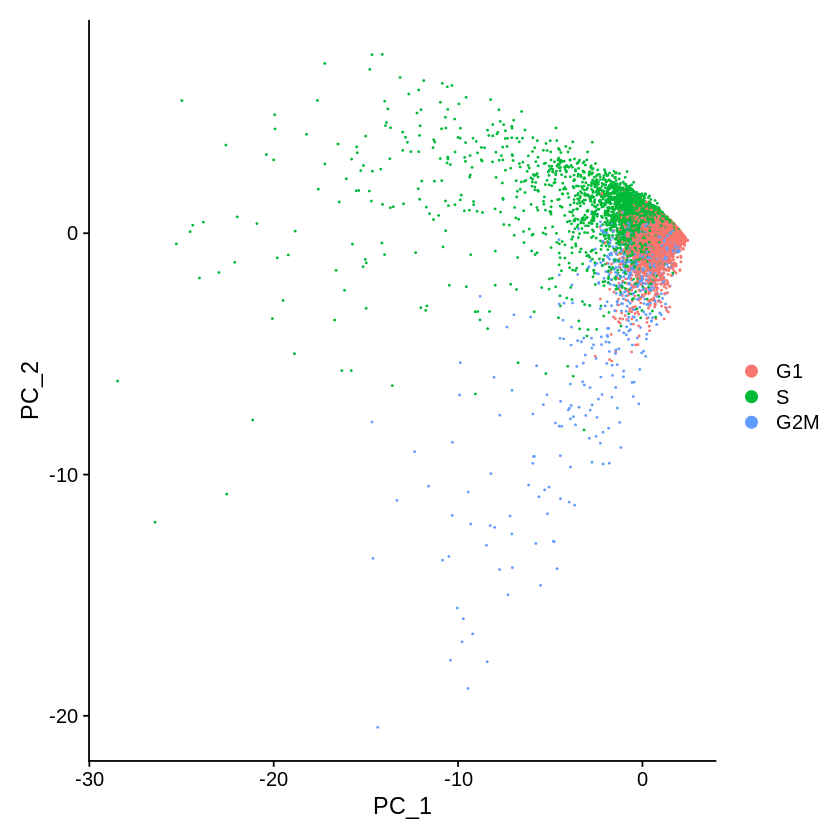

In [17]:
# check cell cycle effect
anndata <- CellCycleScoring(anndata, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)
anndata <- RunPCA(anndata, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
DimPlot(anndata, reduction = 'pca')

In [18]:
anndataO = anndata
# Regress out cell cycle - NOTE: subset the dataset to speed up process
anndata = subset(anndata, features = VariableFeatures(object = anndata))
# anndata <- ScaleData(anndata, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(anndata))

PC_ 1 
Positive:  APOE, FXYD2, PDZK1, BHMT, TMEM176A, DAB2, SMIM24, AFP, GPC3, SLC39A5 
	   CCDC198, SLC3A1, LGALS2, MPC2, TMEM176B, UGT3A1, CYB5A, HGD, CDHR5, DPYS 
	   CUBN, AMN, LINC01781, AGT, ABCC6, CRYL1, SERPINA1, KCNJ15, USH1C, FTL 
Negative:  RNASE1, LGALS3, LYPD1, PNOC, SOX17, BCAT1, ERP27, MSLN, PART1, KRT7 
	   DAPL1, ANXA1, SLC34A2, IFITM3, SPRR2F, DOK5, CMTM6, FILIP1, ANKRD65, SCGB2A1 
	   EHF, KLK11, KIAA1551, UPK3B, SLPI, ABI3BP, FAM107A, PKP2, IGFBP5, TTYH1 
PC_ 2 
Positive:  SPRR2F, MGST3, BEX1, IGFBP4, PCP4, IGFBP3, SPARC, PRSS35, AMHR2, COL1A2 
	   EMP3, CALY, GATA4, PLAU, NRK, SST, TUBA1A, NPY, IGFBP5, SFRP1 
	   COL1A1, MEG3, NUDT10, GADD45G, NR2F2, PLAC1, TCEAL2, FBXO32, GATM, STAR 
Negative:  MSLN, RNASET2, ERP27, FOLR1, CD24, KRT7, CLDN4, CLDN3, SOX17, PNOC 
	   CMTM6, ANXA1, ANKRD65, SCGB2A1, PART1, SLC34A2, MUC1, EHF, KLF5, MECOM 
	   DAPL1, CLDN7, DOK5, FILIP1, C2orf88, PSAT1, UGT2B7, PPP2R2B, CAPS, ADAM28 
PC_ 3 
Positive:  MAL, GATA3, TUBB2B, TFAP2A, DNER,

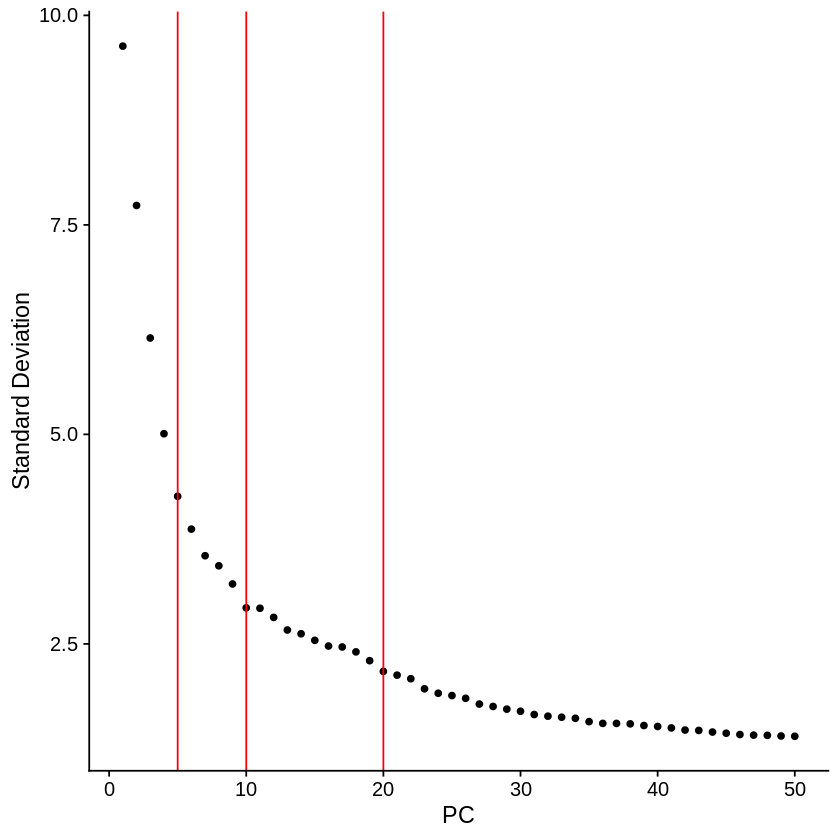

In [19]:
# Compute PCA
anndata <- RunPCA(anndata, features = VariableFeatures(object = anndata), seed.use = 1)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

In [20]:
npca = 9
# Correct donor's effect on PCA
anndata <- RunHarmony(anndata, group.by.vars = 'individual', dims.use = 1:npca, theta = 0, lambda = 10, max.iter.harmony = 30, max.iter.cluster = 30)#, max.iter.harmony = 30, reference_values = c('Hrv3', 'Hrv58')) # sigma=0.2,

Harmony 1/30

Harmony 2/30

Harmony 3/30

Harmony 4/30

Harmony 5/30

Harmony 6/30

Harmony 7/30

Harmony 8/30

Harmony 9/30

Harmony 10/30

Harmony 11/30

Harmony 12/30

Harmony 13/30

Harmony 14/30

Harmony converged after 14 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [21]:
# Cluster
# anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "pca", verbose = F)
# anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "pca", verbose = F)
anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "harmony", verbose = F)
anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "harmony", verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [35]:
anndata <- FindClusters(anndata, resolution = 0.1)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10794
Number of edges: 363516

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9726
Number of communities: 7
Elapsed time: 1 seconds


In [36]:
# Transfer data
all(rownames(anndataO) == rownames(anndata))
anndataO$seurat_clusters = anndata$seurat_clusters
Idents(anndataO) = Idents(anndata)

anndataO@reductions = anndata@reductions

Warning message in rownames(anndataO) == rownames(anndata):
“longer object length is not a multiple of shorter object length”


[1] FALSE

Saving 6.67 x 6.67 in image



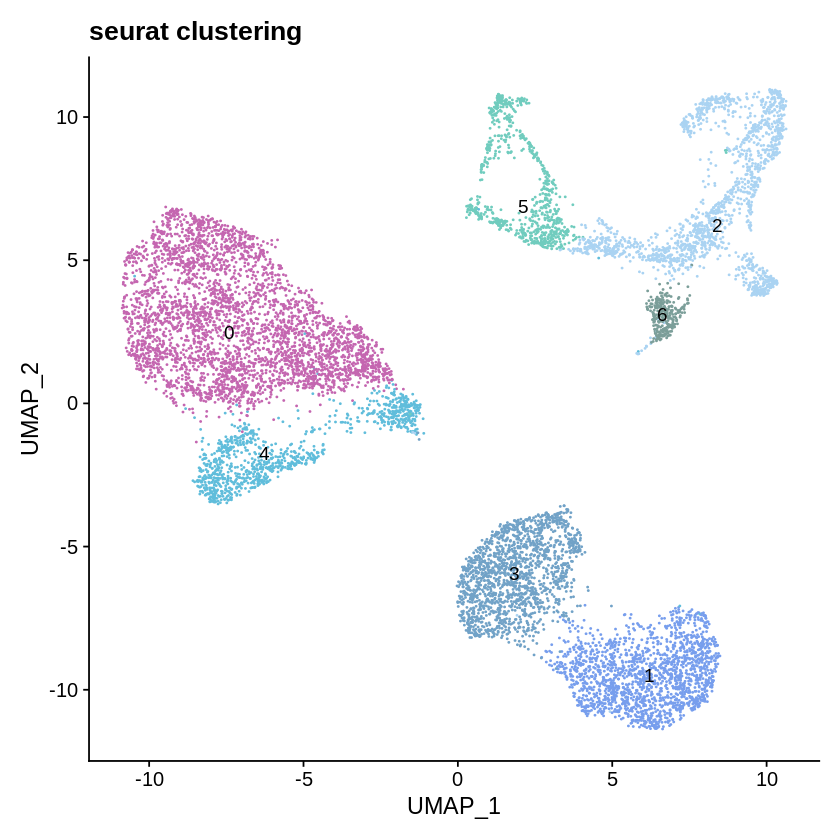

In [37]:
# Visualize
p1 = DimPlot(anndata, reduction = "umap", label = T, cols = colors) + ggtitle('seurat clustering') + NoLegend()
p1
ggsave(filename = paste0('figures-supporting/PAX8_umap_clustering.pdf'), dpi = 75)

Saving 13.3 x 13.3 in image



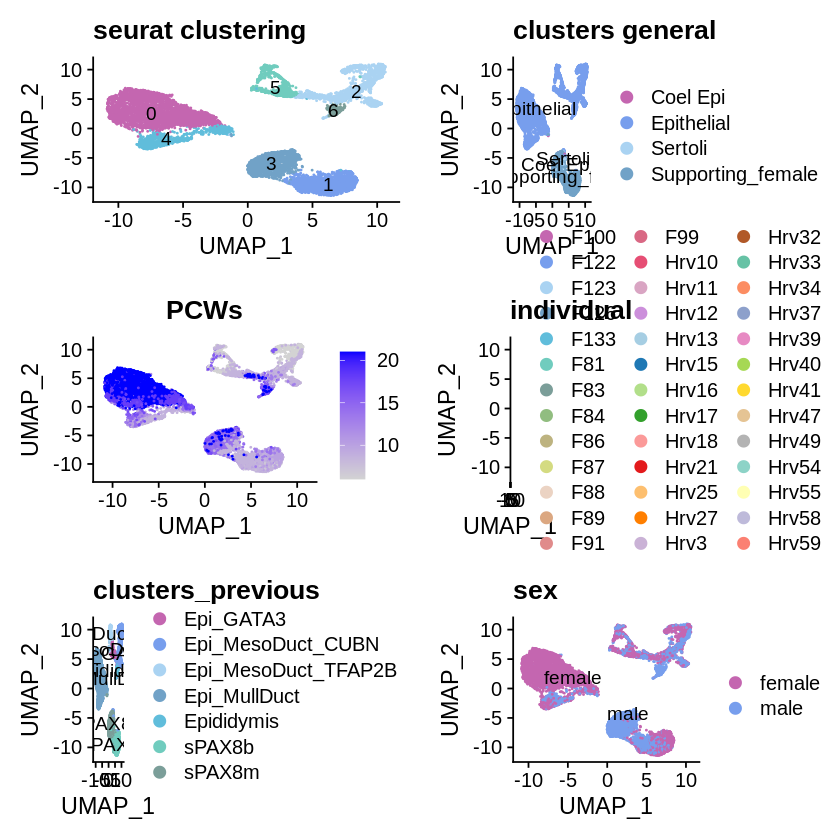

In [38]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'clusters_previous', label = T, cols = colors) + ggtitle('clusters_previous')
p2 = DimPlot(anndata, reduction = "umap", group.by = 'clusters', label = T, cols = colors) + ggtitle('clusters general')
p3 = FeaturePlot(anndata, reduction = "umap", 'PCW') + ggtitle('PCWs')
p4 = DimPlot(anndata, reduction = "umap", group.by = 'individual', cols = colors) + ggtitle('individual')
p5 = DimPlot(anndata, reduction = "umap", group.by = 'clusters_previous',  label = T, cols = colors) + ggtitle('clusters_previous')
p6 = DimPlot(anndata, reduction = "umap", group.by = 'sex',  label = T, cols = colors) + ggtitle('sex')
plot_grid(p1, p2, p3, p4, p5, p6, ncol = 2)
ggsave(filename = paste0('figures-supporting/PAX8_umap_metadata.pdf'), scale = 2, dpi = 75)

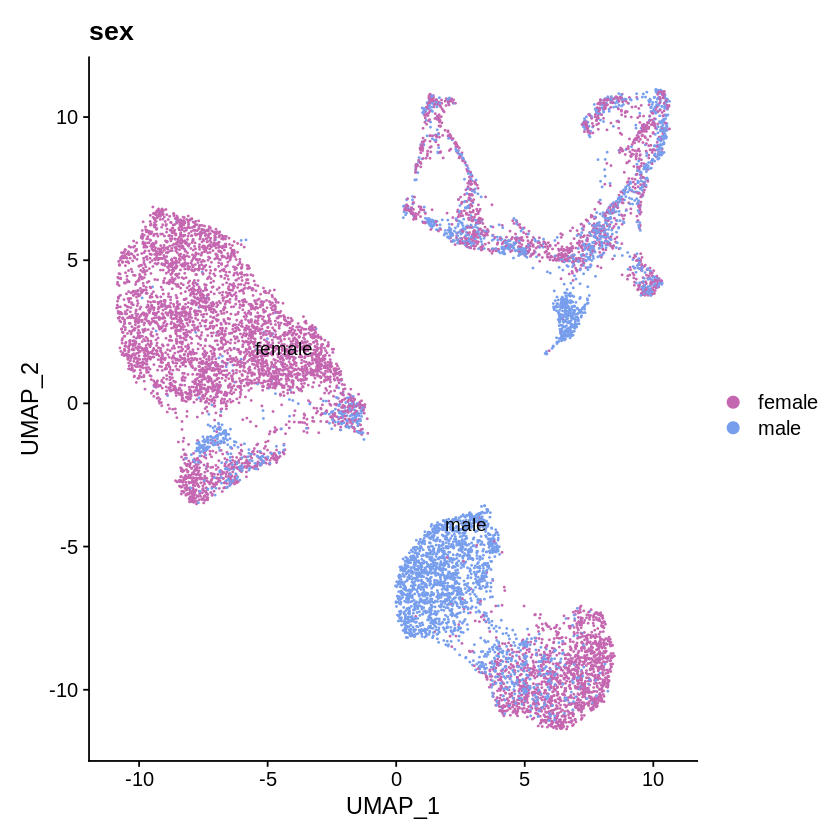

In [39]:
p6

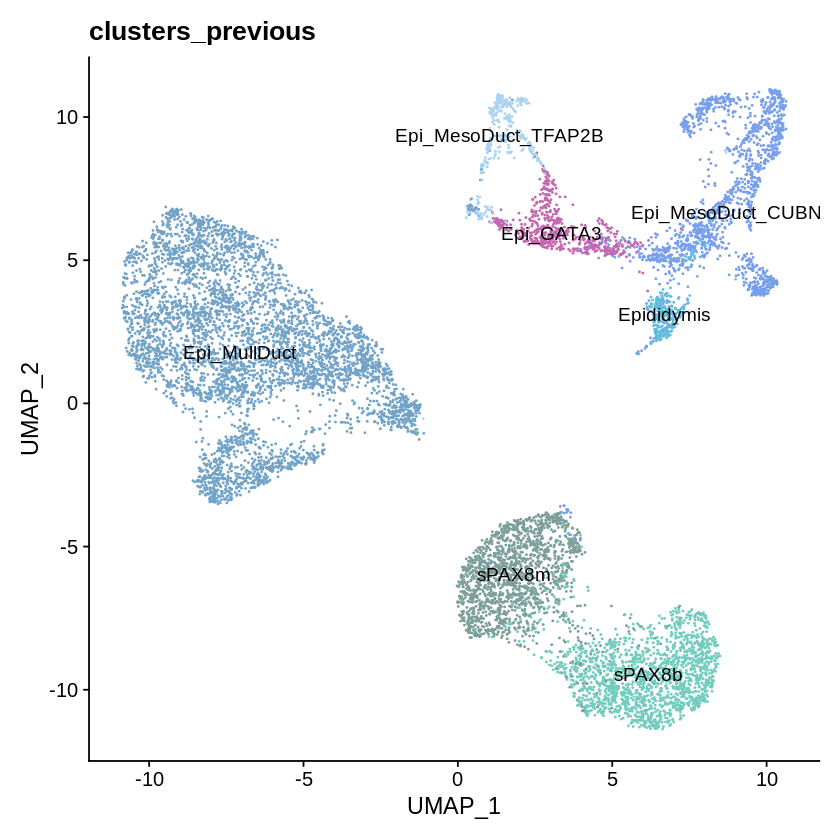

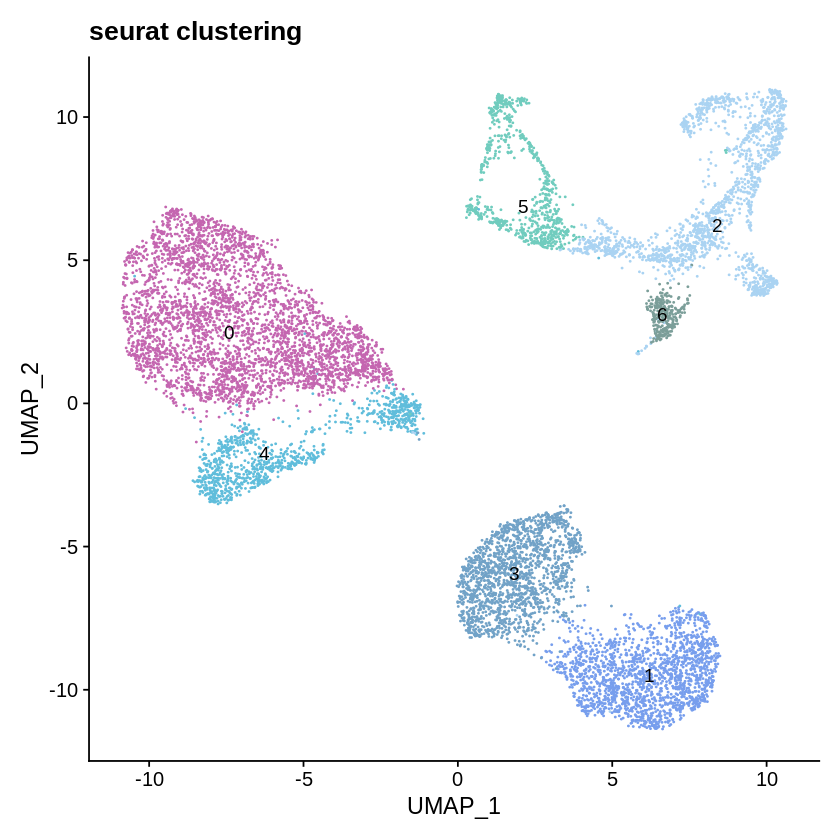

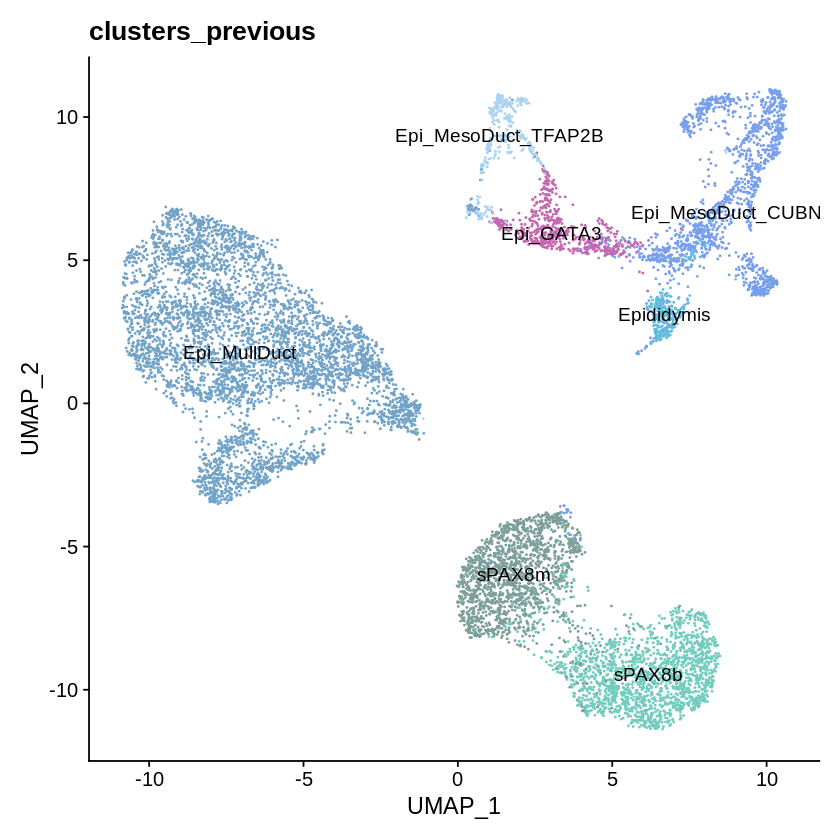

In [40]:
p1b + NoLegend()
p1
p5 + NoLegend()

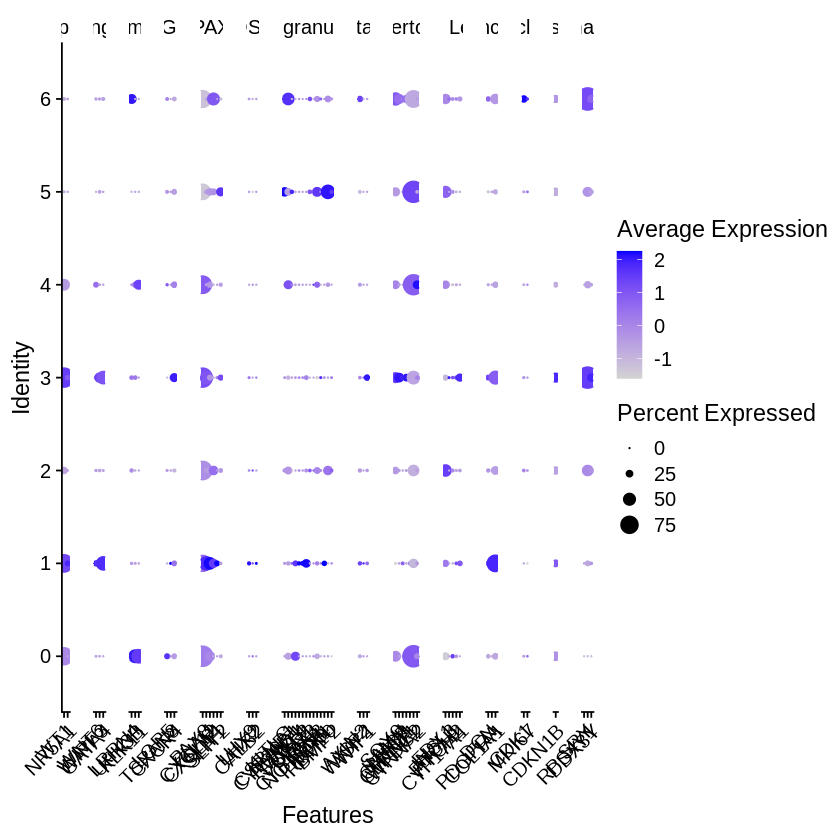

In [41]:
DotPlot(anndataO, features = markers, group.by = 'seurat_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-supporting/PAX8_dotplot_markers.pdf'), dpi = 75, height = 7, width = 30)

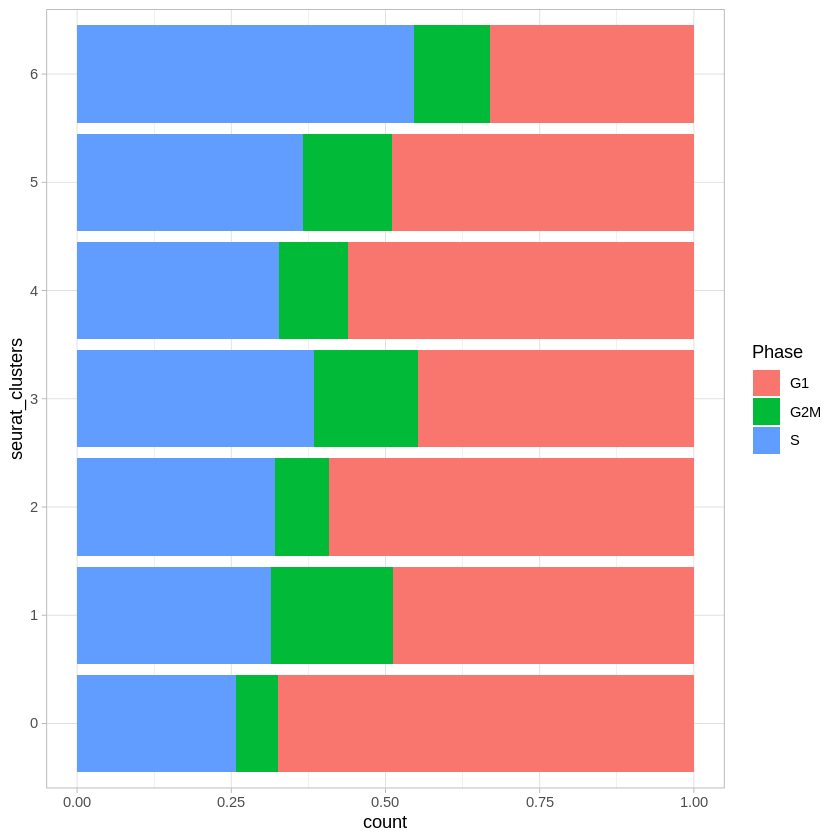

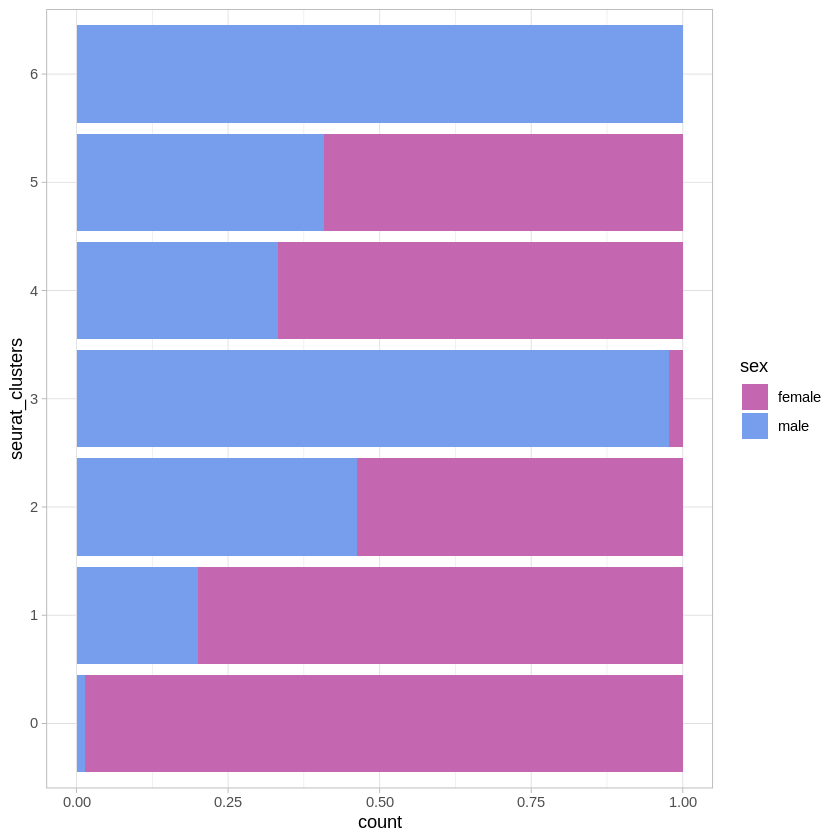

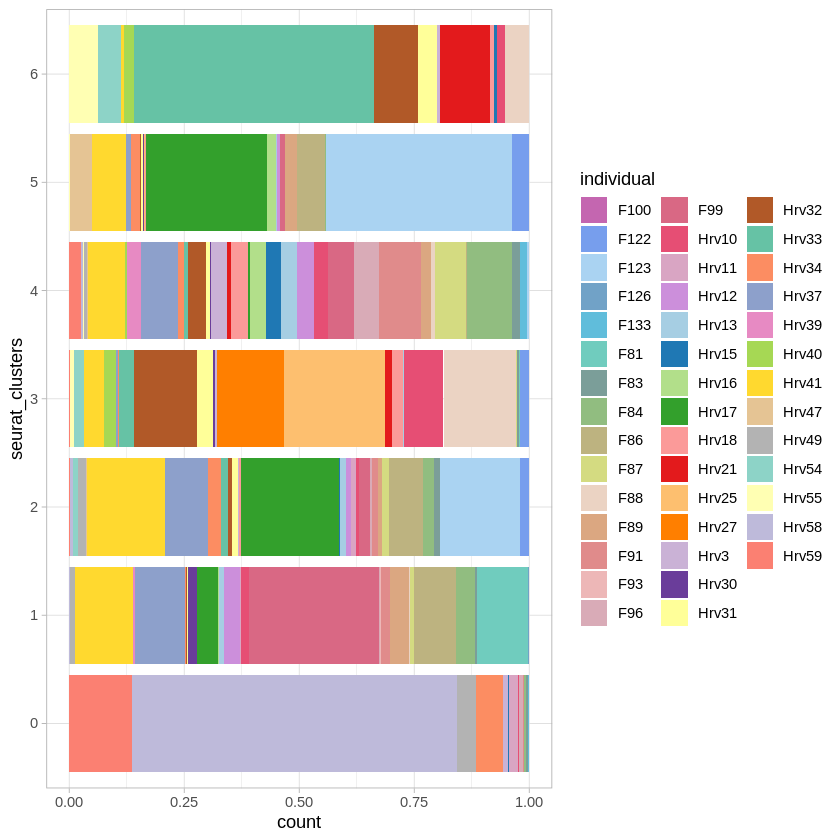

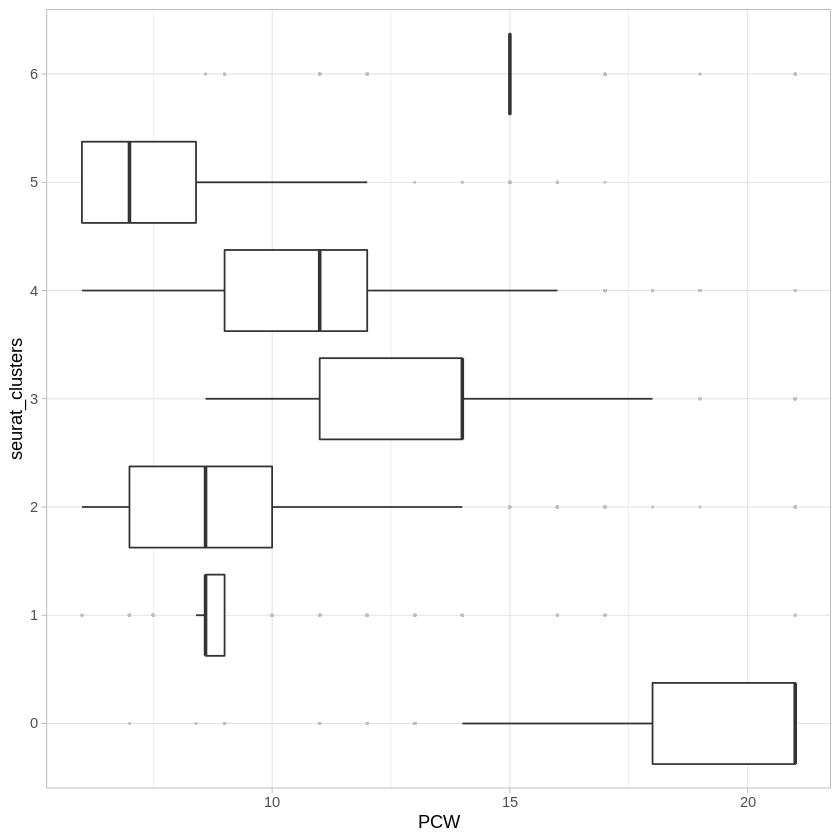

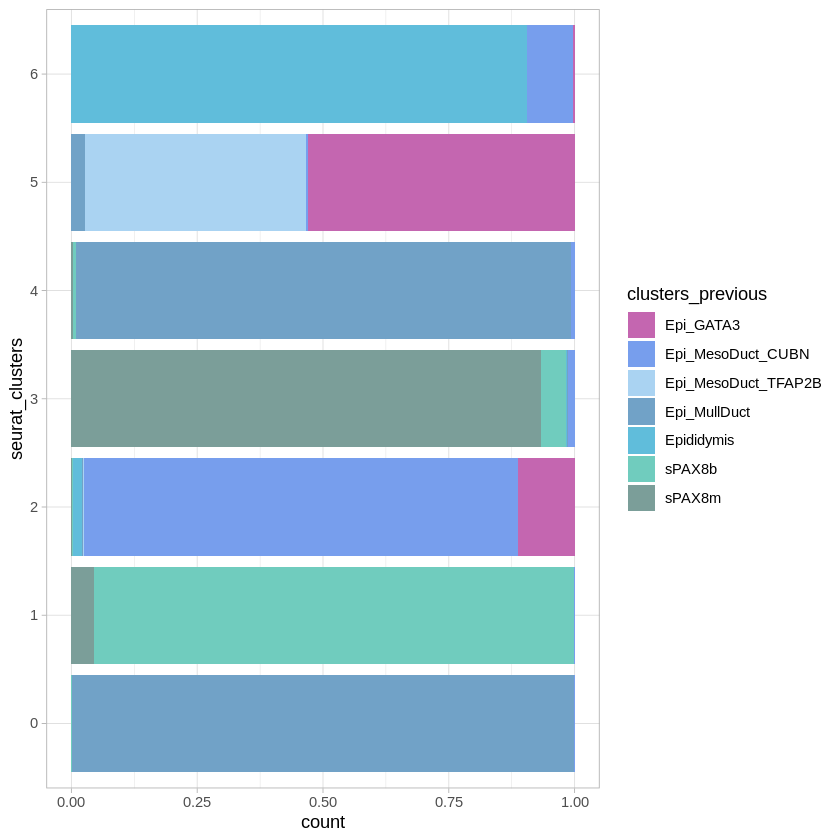

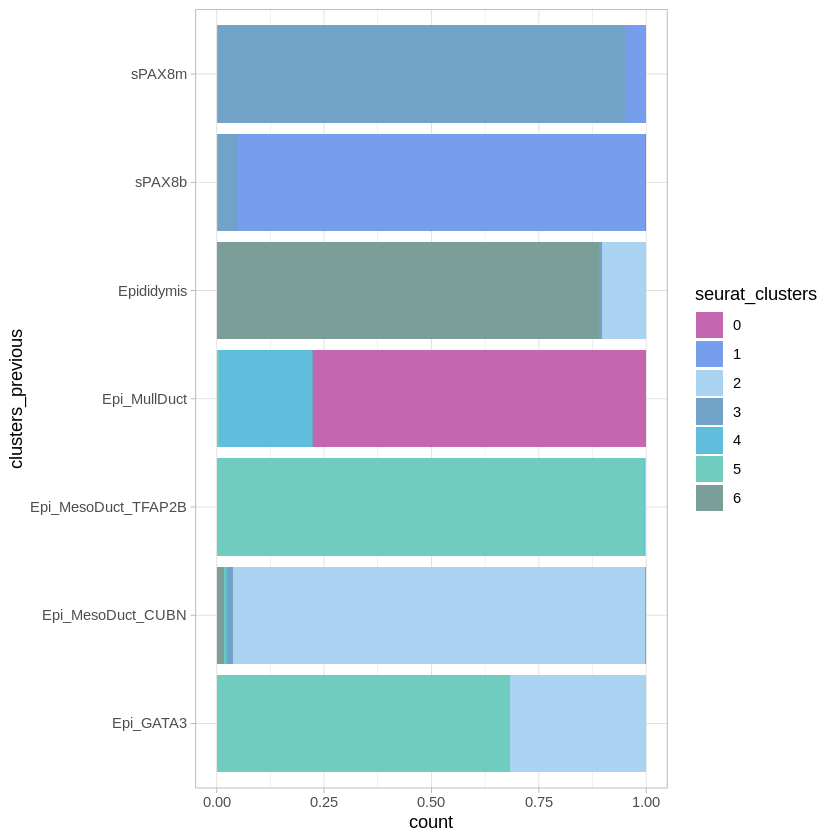

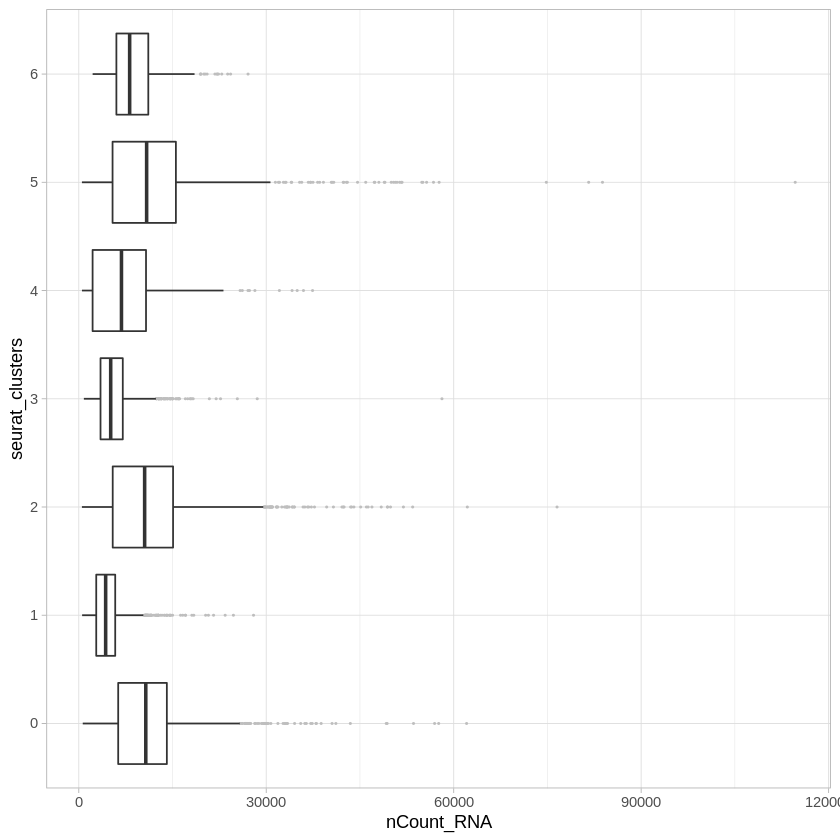

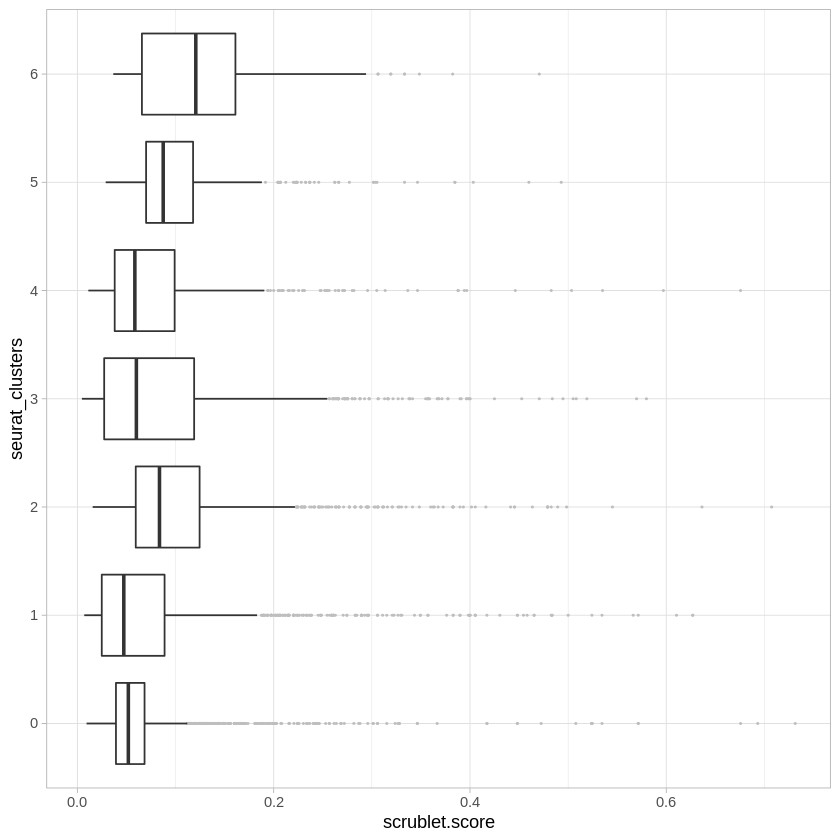

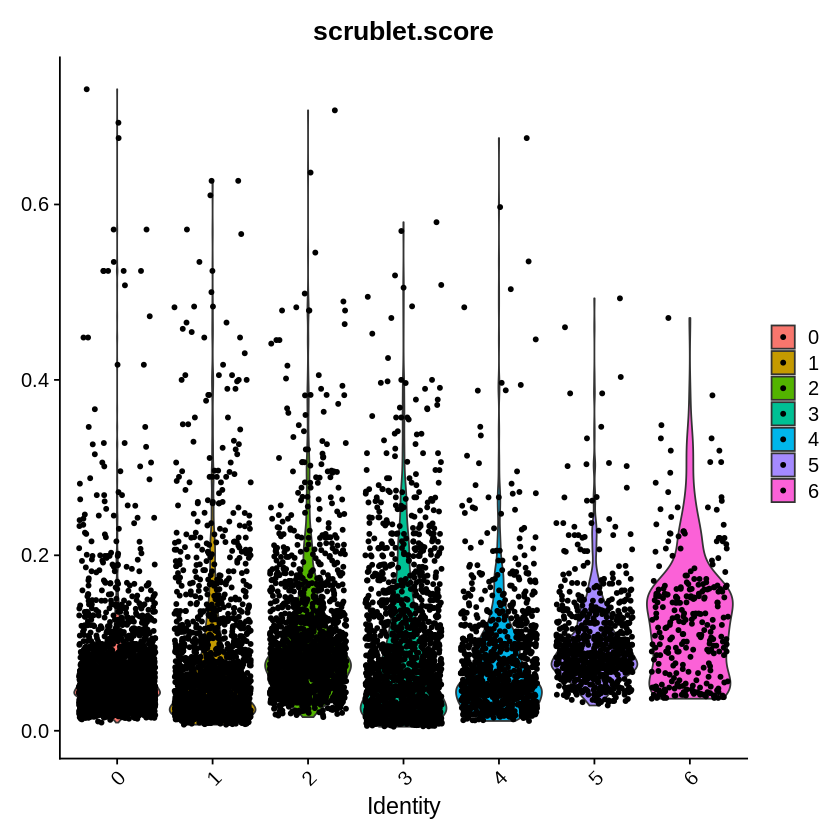

In [48]:
ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()

ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()


ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()



ggplot(anndata@meta.data, aes(x = seurat_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()


ggplot(anndata@meta.data, aes(x = seurat_clusters , fill = clusters_previous )) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x =  clusters_previous, fill = seurat_clusters  )) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

ggplot(anndataO@meta.data, aes(x = seurat_clusters, y = nCount_RNA)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
ggplot(anndata@meta.data, aes(x = seurat_clusters, y = scrublet.score)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()

VlnPlot(anndata, 'scrublet.score')

### DEGs and GSA

In [49]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 20)
dim(df_tfIDF)
# write.csv(df_tfIDF, file = 'figures-supporting/PAX8_cluster_markersTFIDF.csv', quote = F, row.names = F)

[1] 140  10

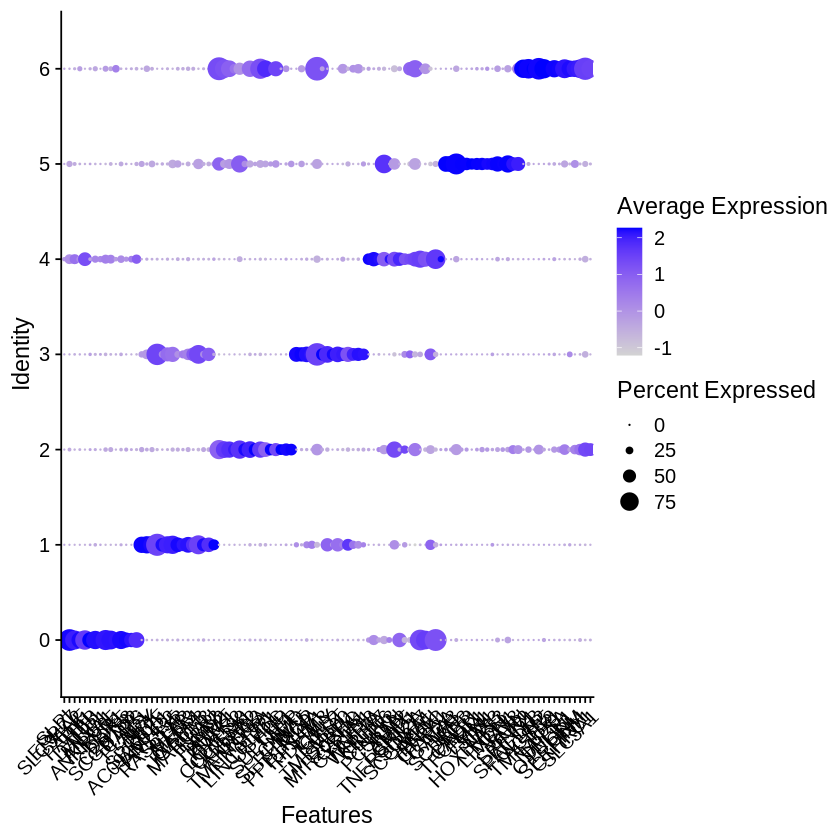

In [50]:
df_tfIDF$cluster = as.numeric(df_tfIDF$cluster)
df_tfIDF = df_tfIDF[ order(df_tfIDF$cluster), ]
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'seurat_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-supporting/PAX8_dotplot_TFIDF_DEGs.pdf'), dpi = 75, height = 5, width = 45)

# Annotate clusters

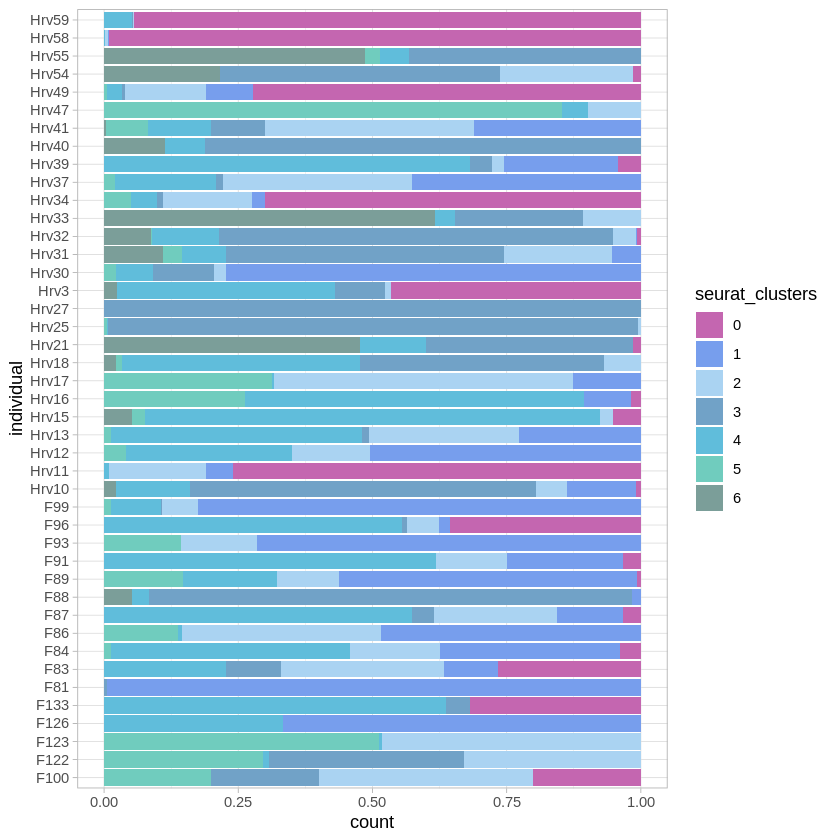

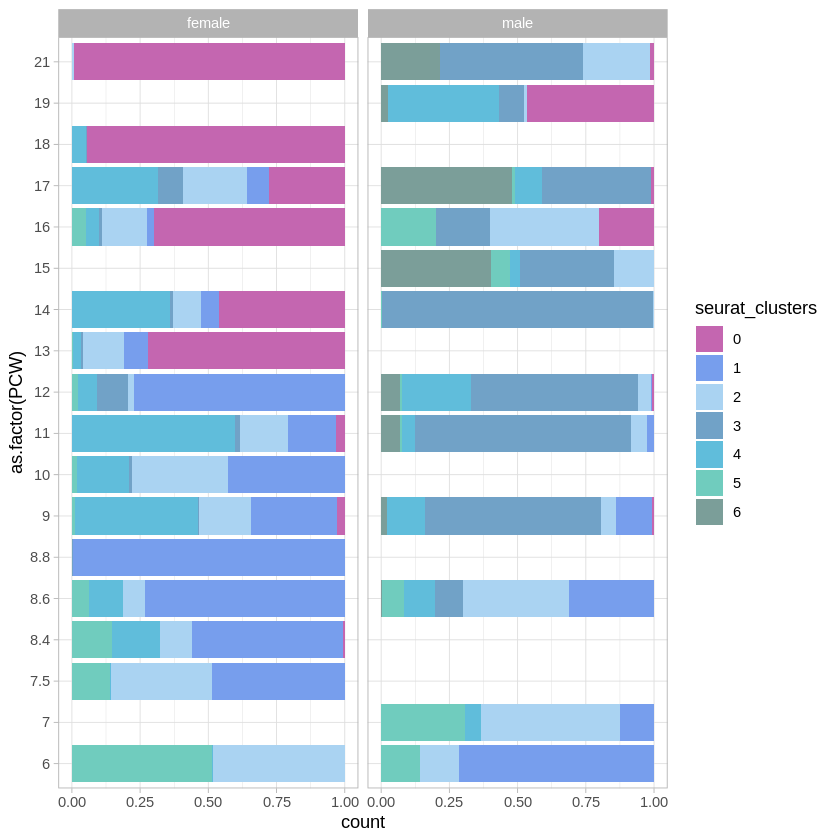

In [51]:
ggplot(anndata@meta.data, aes(x = individual , fill = seurat_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x = as.factor(PCW) , fill = seurat_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +  facet_wrap(~sex) +
    scale_fill_manual(values = colors) + theme_light()

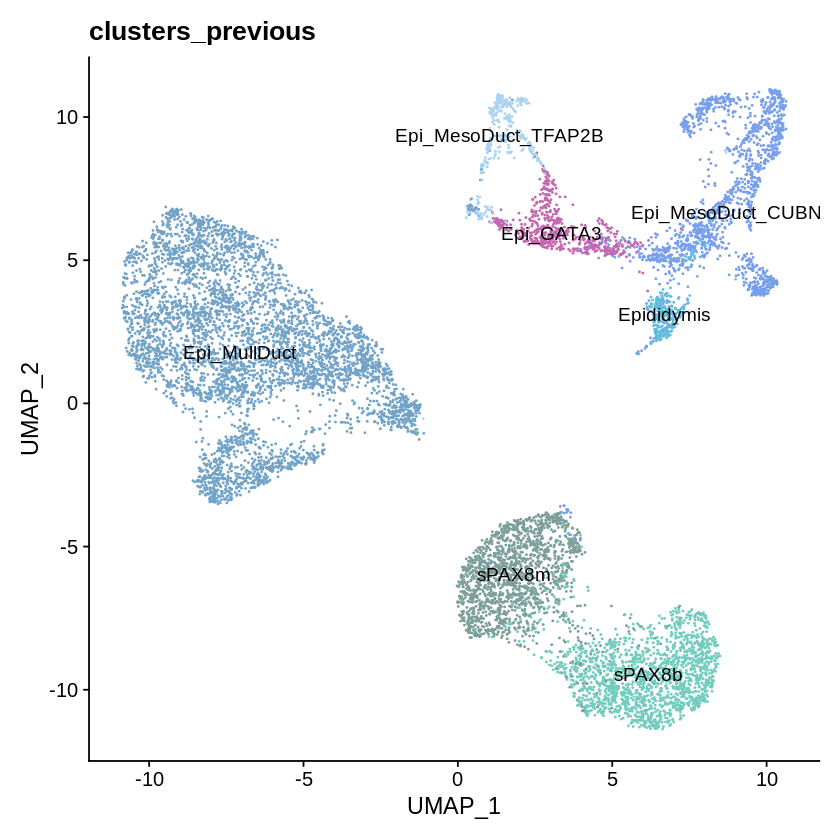

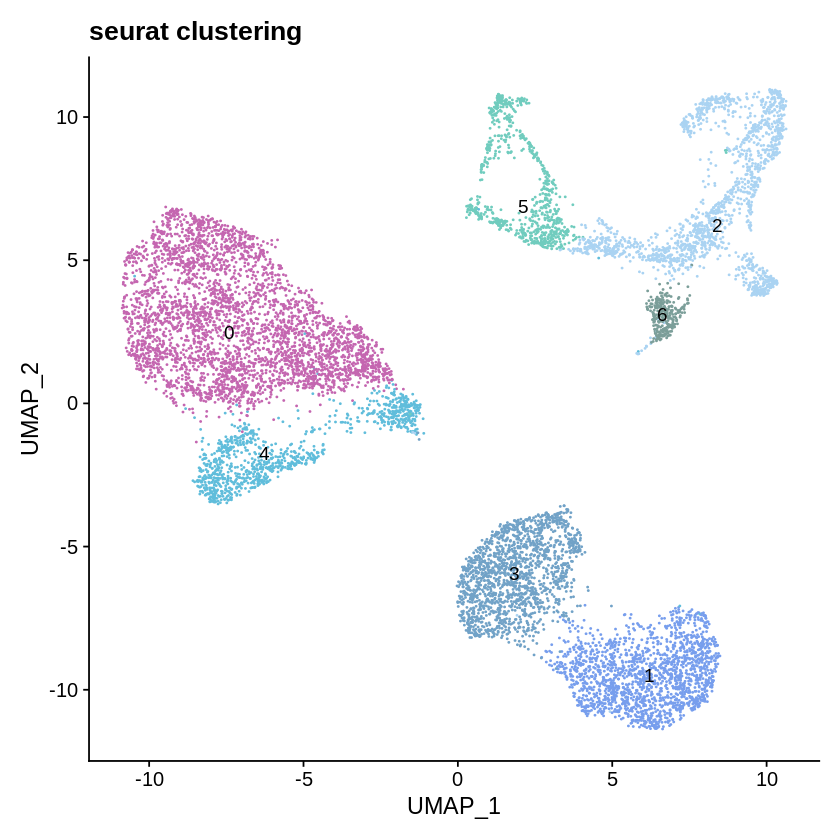

In [52]:
p1b + NoLegend()
p1

In [53]:
# import annotation
anndata@meta.data$annotated_clusters = anndata@meta.data$clusters_previous
anndata@meta.data$annotated_clusters = factor(anndata@meta.data$annotated_clusters, levels = unique(sort(anndata@meta.data$clusters_previous)))

Idents(anndata) = anndata@meta.data$annotated_clusters
anndataO@meta.data$annotated_clusters = anndata@meta.data$annotated_clusters
Idents(anndataO) = anndataO@meta.data$annotated_clusters

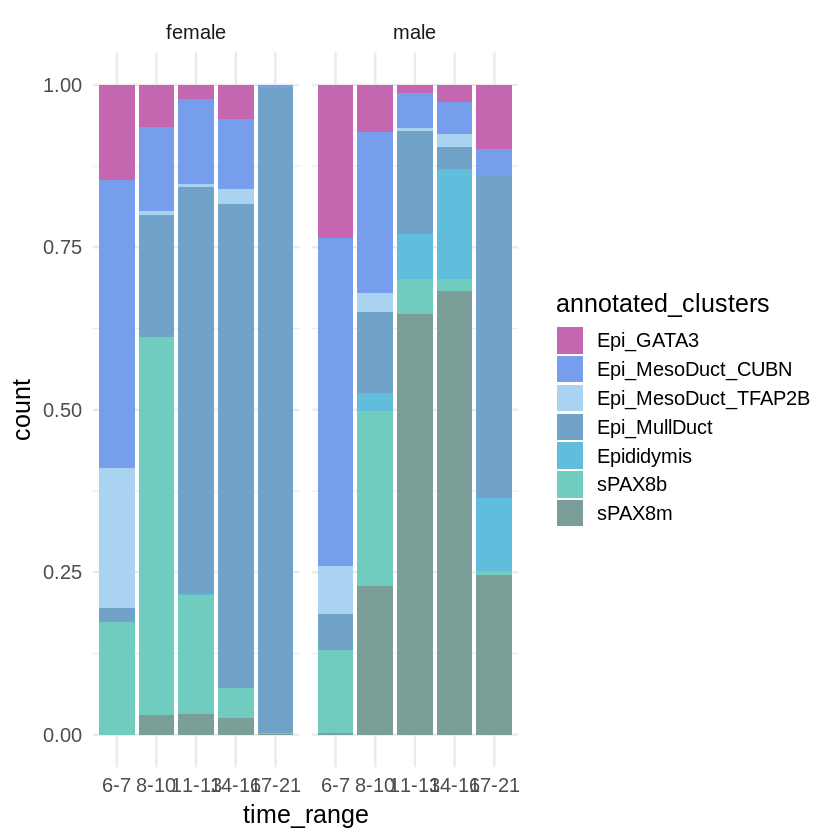

In [54]:
anndataO@meta.data$time_range = '6-7'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 8 ] = '8-10'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 11 ] = '11-13'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 14 ] = '14-16'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >17 ] = '17-21'
anndataO@meta.data$time_range = factor(anndataO@meta.data$time_range, levels = c('6-7', '8-10', '11-13', '14-16', '17-21') )
ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = luz_colors) +
    facet_wrap(~sex)+
    geom_bar(position = 'fill')+
#     geom_bar()+
    theme_minimal(15)

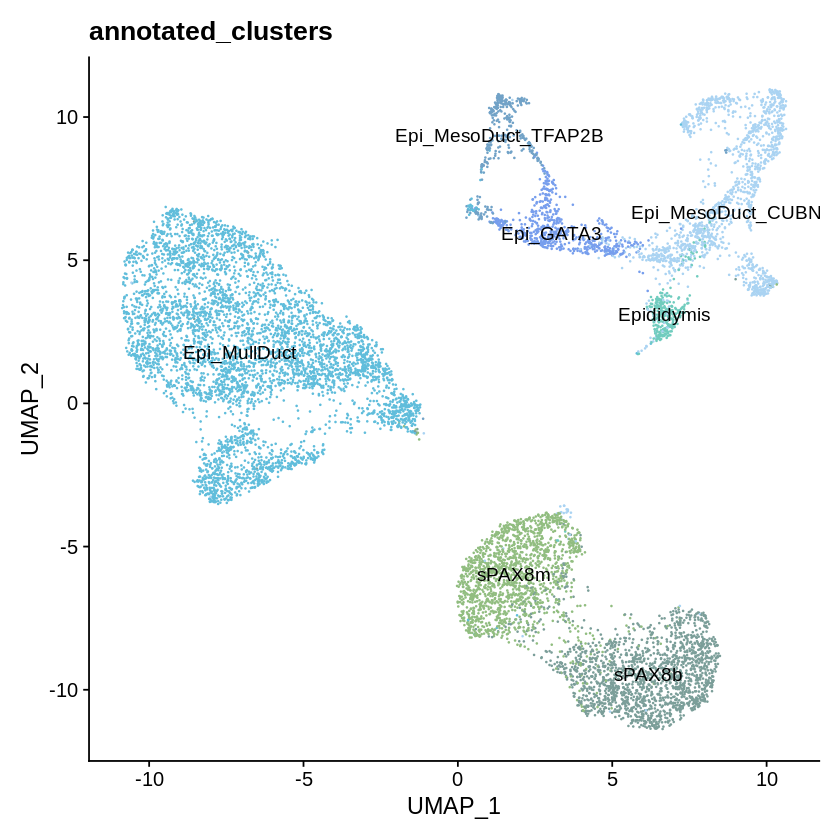

In [55]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'annotated_clusters', label = T, pt.size = 0.1,
             cols = colors[-1] ) + ggtitle('annotated_clusters')
p1b+ NoLegend()
ggsave(filename = paste0('figures-supporting/PAX8_umap_annotated.pdf'), dpi = 75, width = 7, height = 7)

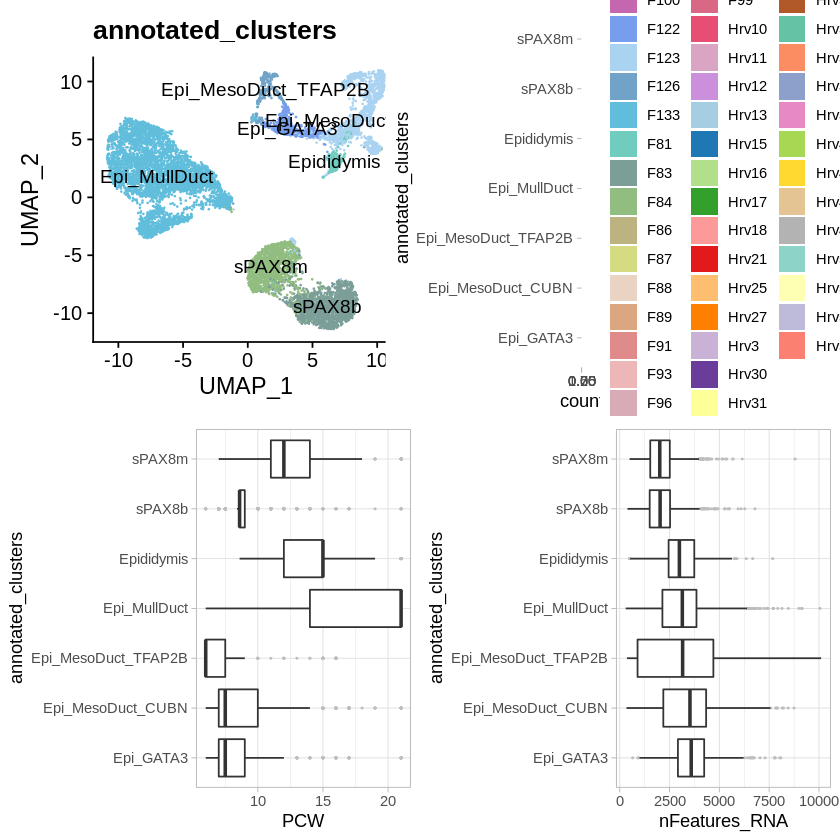

In [56]:
b1 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b2 = ggplot(anndata@meta.data, aes(x = annotated_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
b3 = ggplot(anndata@meta.data, aes(x = annotated_clusters, y = nFeatures_RNA)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
plot_grid(p1b+NoLegend(), b1, b2, b3, ncol = 2)
ggsave(filename = paste0('figures-supporting/PAX8_metadata_annotated.pdf'), dpi = 75, width = 10, height = 10)

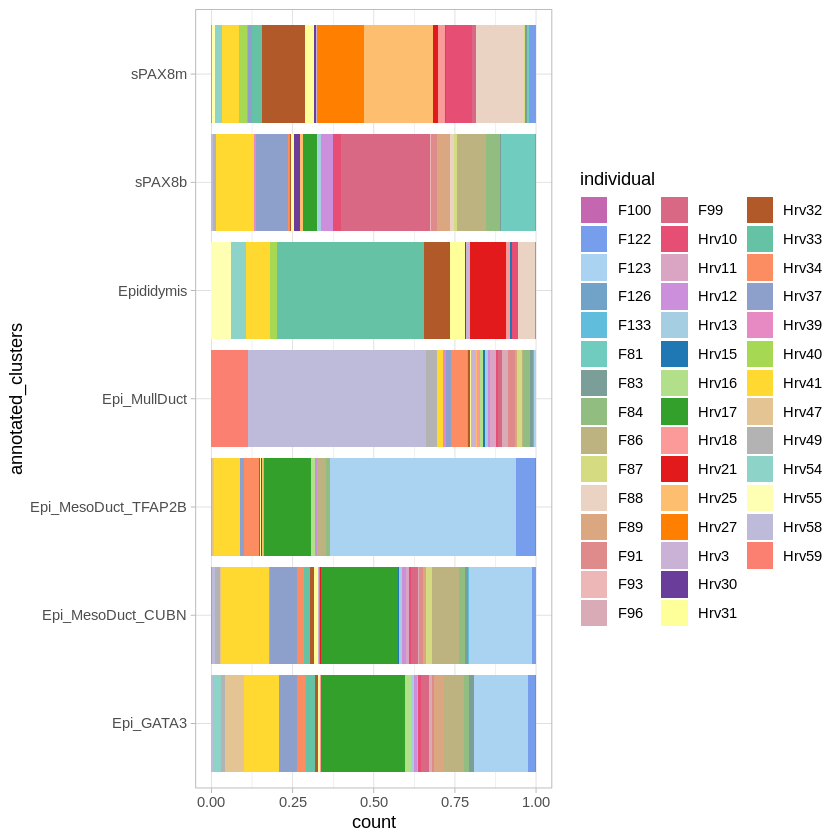

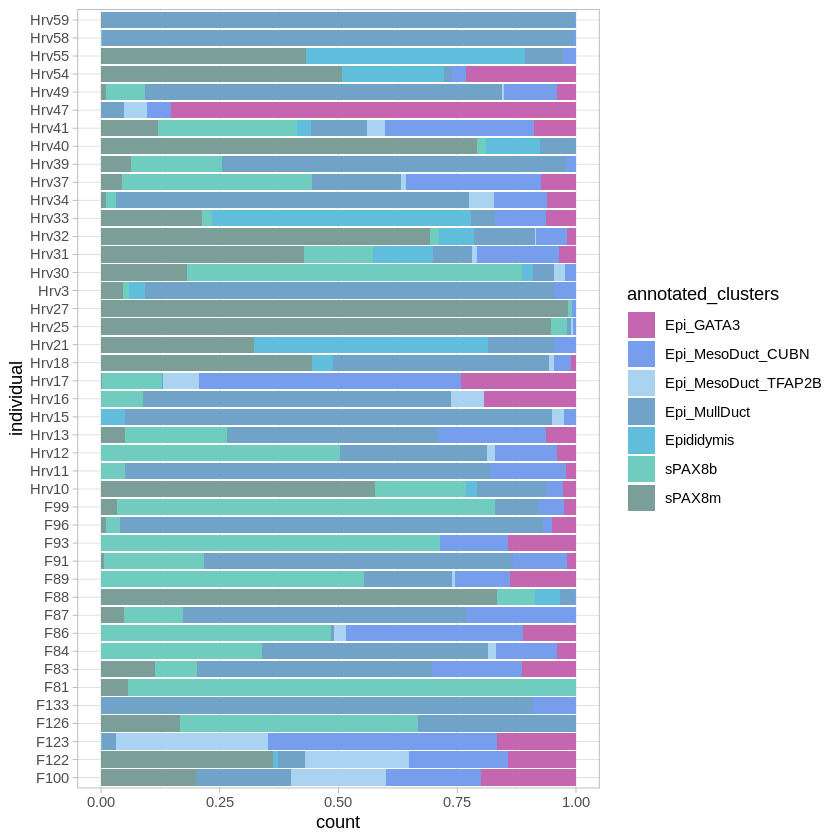

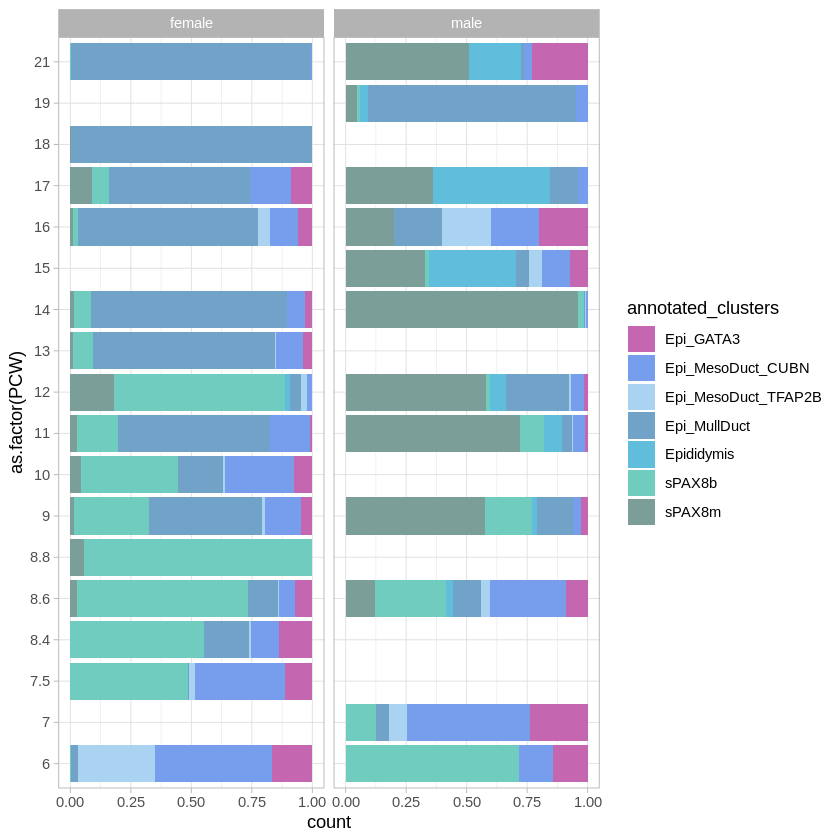

In [57]:
ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x = individual , fill = annotated_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x = as.factor(PCW) , fill = annotated_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +  facet_wrap(~sex) +
    scale_fill_manual(values = colors) + theme_light()

In [58]:
# write.csv(anndata@meta.data, file = paste0('figures-supporting/definitive_annotation.csv'), quote = F, row.names = T)

# Markers

In [59]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 100)
dim(df_tfIDF)
# write.csv(df_tfIDF, file = 'figures-supporting/PAX8_cluster_markersTFIDF_annotated.csv', quote = F, row.names = F)

[1] 700  10

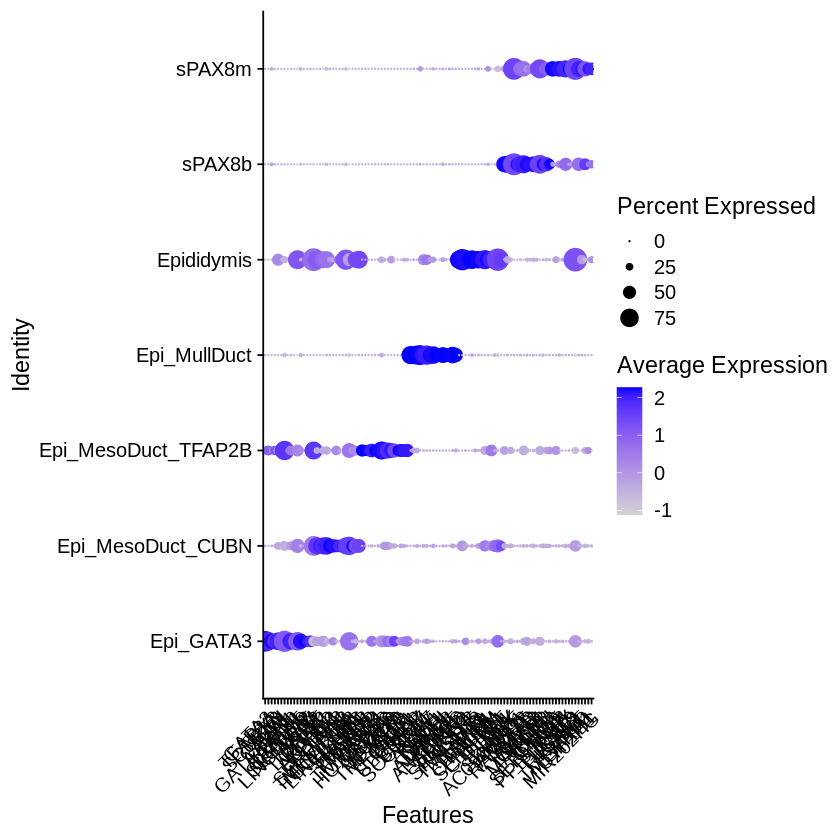

In [60]:
df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO@meta.data$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-supporting/PAX8_dotplot_TFIDF_DEGs_annotated.pdf'), dpi = 75, height = 5, width = 45)

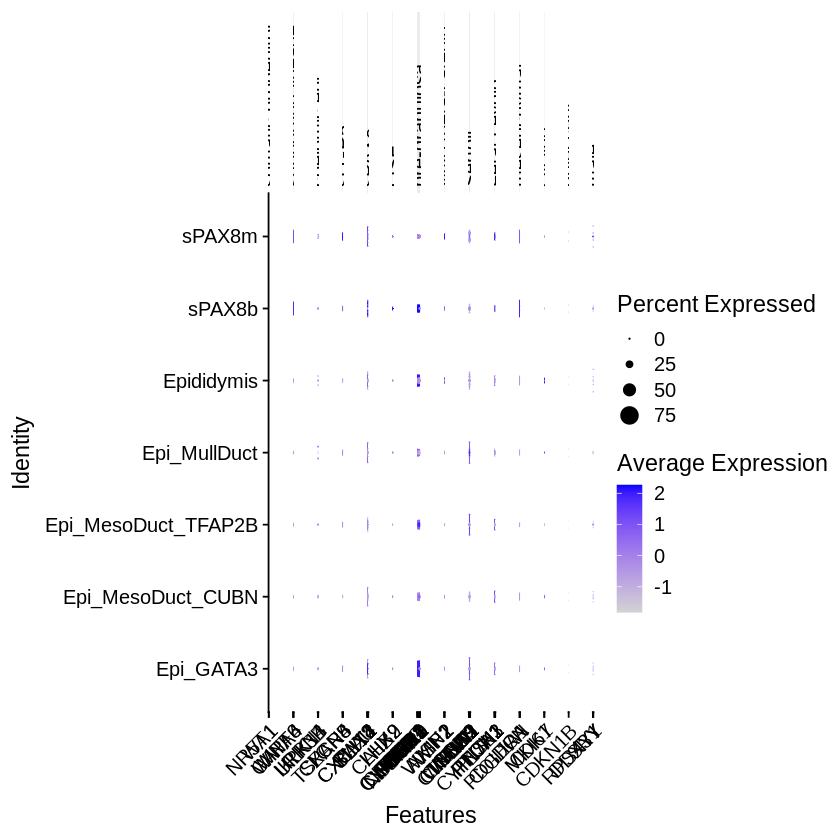

In [61]:
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-supporting/PAX8_dotplot_markers_annotated.pdf'), dpi = 75, height = 7, width = 25)

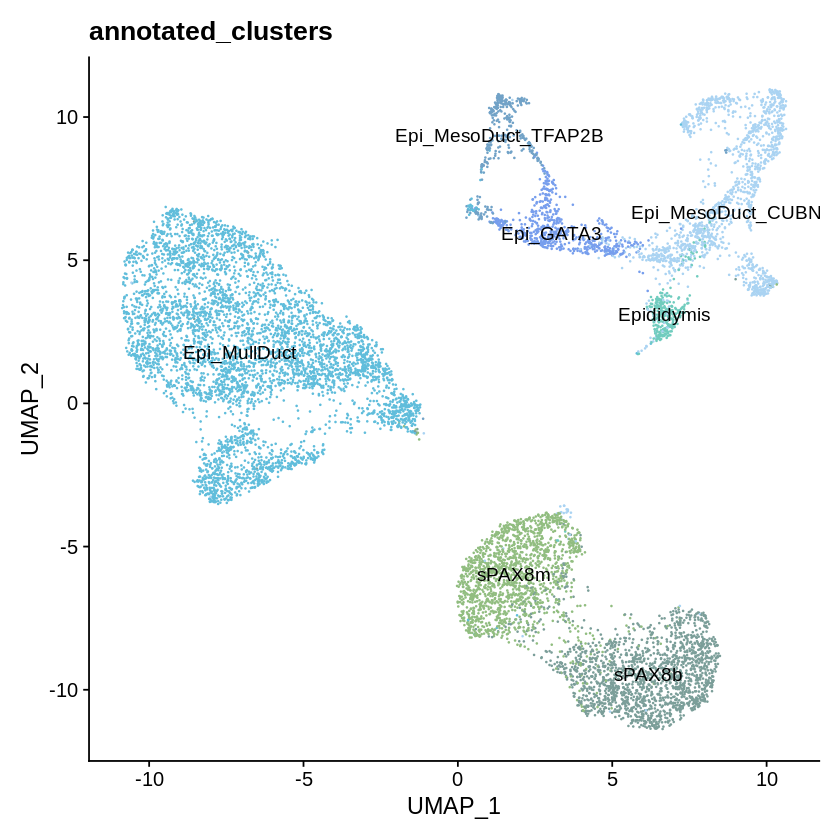

Saving 13.3 x 13.3 in image



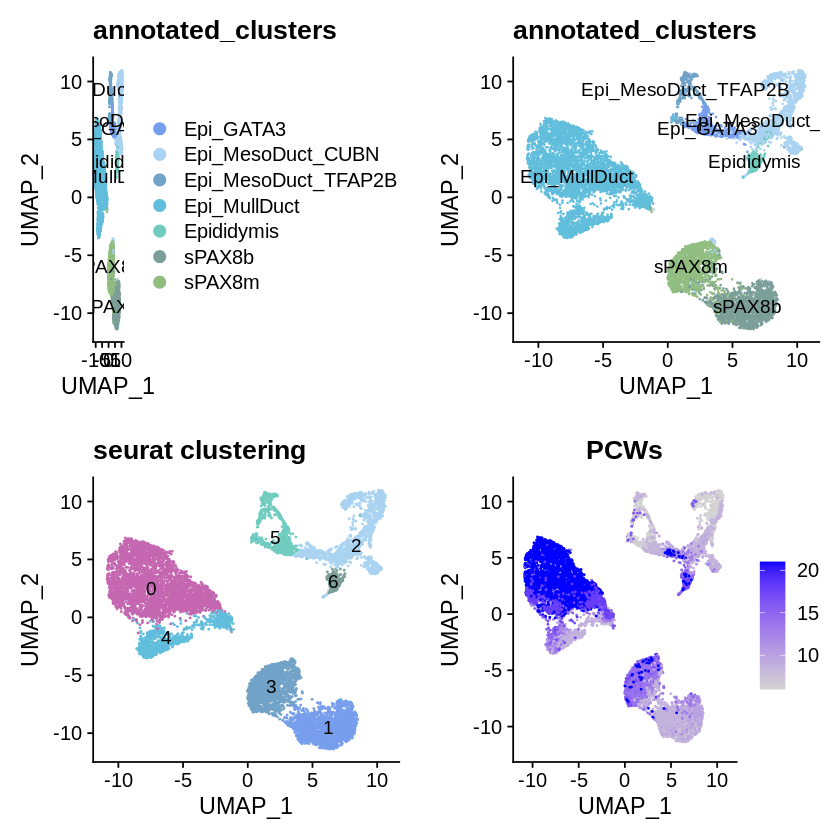

In [62]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'annotated_clusters', label = T, pt.size = 0.1,
             cols = colors[-1] ) + ggtitle('annotated_clusters')
p1b+ NoLegend()

plot_grid(p1b, p1b+ NoLegend(), p1, p3, ncol = 2)
ggsave(filename = paste0('figures-supporting/PAX8_umap_annotated.pdf'), dpi = 75, scale = 2)

Saving 10.7 x 10.7 in image



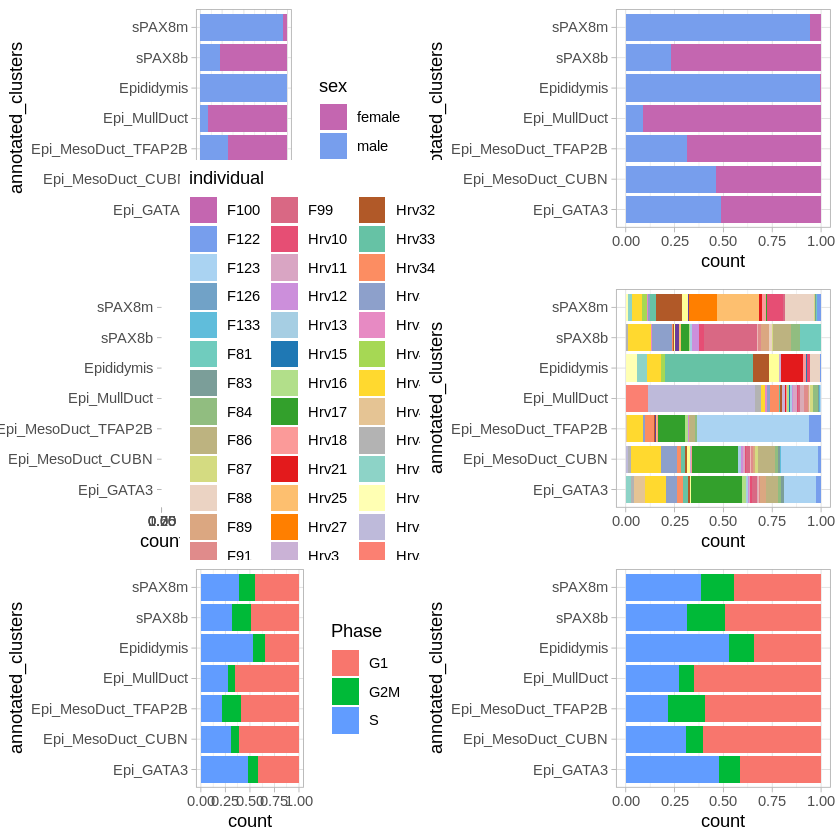

In [63]:
b1 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b2 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b3 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()
plot_grid(b1, b1+NoLegend(), b2, b2+NoLegend(),  b3, b3+NoLegend(), ncol = 2)
ggsave(filename = paste0('figures-supporting/PAX8_barplots_annotated.pdf'), dpi = 75, scale = 1.6)

Saving 12 x 6.67 in image



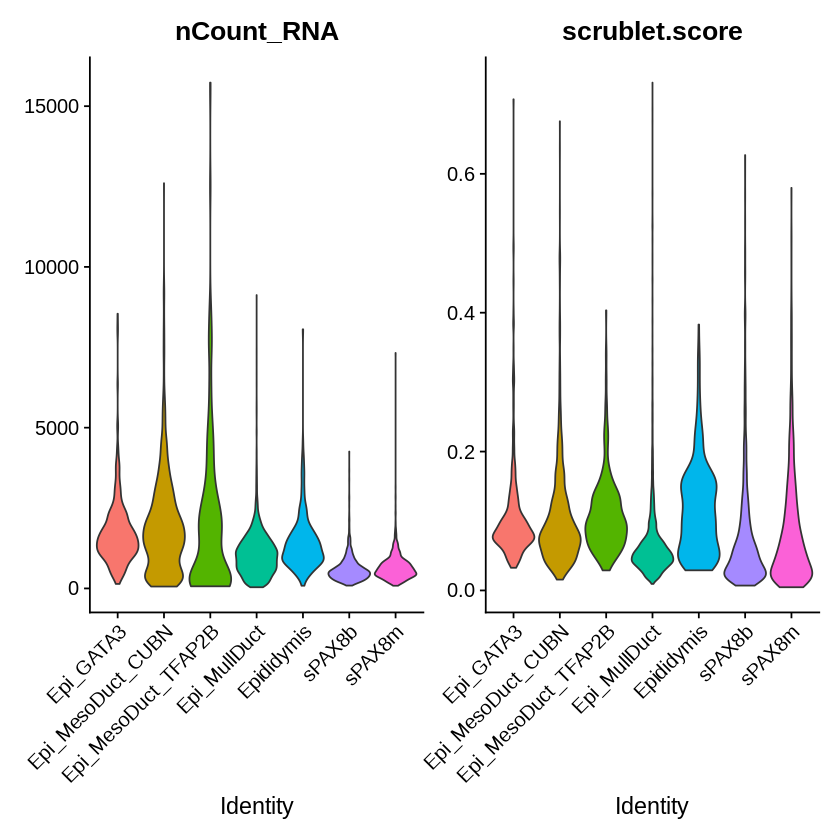

In [64]:
VlnPlot(anndata, c('nCount_RNA', 'scrublet.score'), pt.size = 0)
ggsave(filename = paste0('figures-supporting/PAX8_boxplots_annotated.pdf'), dpi = 75, width = 12)

# TFIDF and Markers

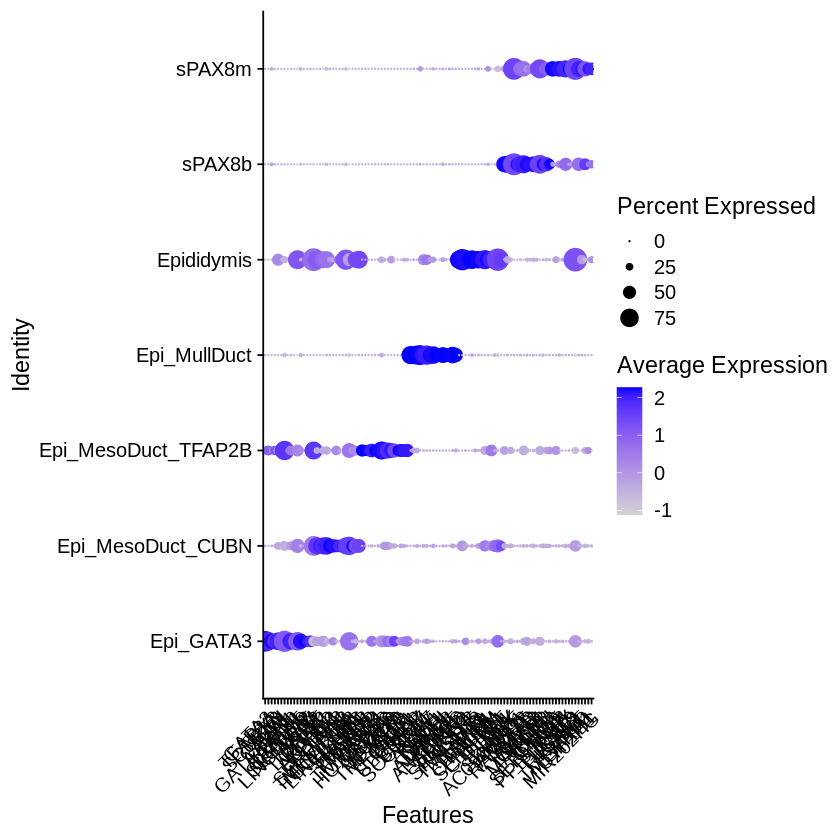

In [65]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 100)
write.csv(df_tfIDF, file = 'figures-supporting/PAX8_cluster_markersTFIDF_annotated.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO@meta.data$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-supporting/PAX8_dotplot_TFIDF_DEGs_annotated.pdf'), dpi = 75, height = 5, width = 45)

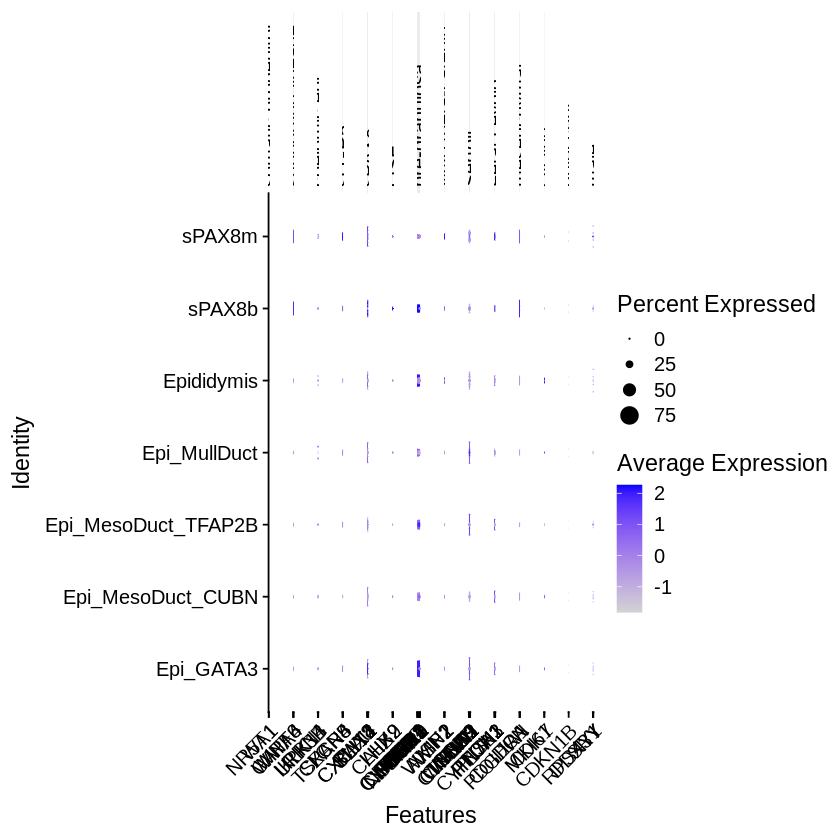

In [66]:
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-supporting/PAX8_dotplot_markers_annotated.pdf'), dpi = 75, height = 7, width = 25)

# Save

In [72]:
write.csv(anndata@meta.data, file = '/nfs/team292/lg18/with_valentina/PAX8epi_annotation.csv', quote = F, row.names = T)
saveRDS(anndataO, file = '/nfs/team292/lg18/with_valentina/PAX8epi.rds')